# Presentation slides

[Google Slides](https://docs.google.com/presentation/d/1upwqZ6aUmanBl_KgIqDycoEBqGksXrgH-7lGAK8OJG0/edit#slide=id.g330630ba414_0_59)

# Setup

In [ ]:
try:
    import rpy2
    print("rpy2 is already installed")
except ImportError:
    !pip install rpy2
    print("rpy2 has been installed")

rpy2 is already installed


In [ ]:
# Load the rpy2 extension
%load_ext rpy2.ipython

In [ ]:
%%R
# List the needed packages
packages <- c("grf", "gtools", "ggplot2", "car")

# Install any package that is not already installed
for (pkg in packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, repos = "http://cran.rstudio.com/")
    library(pkg, character.only = TRUE)
  }
}

# Import the data

In [ ]:
%%R
# Data URL from GitHub
data_url <- "https://raw.githubusercontent.com/pakmasha99/2025-Connectome-Workshop-GRF-Session/refs/heads/main/data.csv"

# Import the dataset from the URL
data <- read.csv(data_url, header = TRUE)

print("Successfully imported the data")

[1] "Successfully imported the data"


In [ ]:
%%R
# Explore the data
cat("Total number of subjects:", nrow(data), "\n")
cat("Total number of variables:", length(names(data)), "\n")
cat("\nVariable names:\n")
names(data)

Total number of subjects: 1000 
Total number of variables: 68 

Variable names:
 [1] "ptsd_score"                 "media_exposure"            
 [3] "src_subject_id"             "demo_sex_v2"               
 [5] "demo_comb_income_v2"        "demo_prnt_ed_v2"           
 [7] "demo_prnt_marital_v2_1"     "demo_prnt_marital_v2_2"    
 [9] "demo_prnt_marital_v2_3"     "demo_prnt_marital_v2_4"    
[11] "demo_prnt_marital_v2_5"     "demo_prnt_marital_v2_6"    
[13] "race_ethnicity_1"           "race_ethnicity_2"          
[15] "race_ethnicity_3"           "race_ethnicity_4"          
[17] "race_ethnicity_5"           "site_id_l"                 
[19] "interview_age"              "smri_vol_cdk_cuneuslh"     
[21] "smri_vol_cdk_lobfrlh"       "smri_vol_cdk_parahpallh"   
[23] "smri_vol_cdk_pericclh"      "smri_vol_cdk_pclh"         
[25] "smri_vol_cdk_rracatelh"     "smri_vol_cdk_sufrlh"       
[27] "smri_vol_cdk_smlh"          "smri_vol_cdk_frpolelh"     
[29] "smri_vol_cdk_tmpolelh"      "smr

# Prepare the data

### Skipped preprocessing steps

* data cleaning (ex: data quality check, handling missing data)
* dummy coding
* removing nero-zero-variance features

### Z-scaling

In [ ]:
%%R
# Choose variables that do not need z-scaling (binary and character variables)
no_scaling <- c('media_exposure', 'src_subject_id','demo_sex_v2',
                'demo_prnt_marital_v2_1','demo_prnt_marital_v2_2','demo_prnt_marital_v2_3','demo_prnt_marital_v2_4','demo_prnt_marital_v2_5','demo_prnt_marital_v2_6',
                'race_ethnicity_1','race_ethnicity_2','race_ethnicity_3','race_ethnicity_4','race_ethnicity_5', 'site_id_l')

# Scale the rest
scale_vars <- names(data)[!(names(data) %in% no_scaling)]

for(i in 1:ncol(data)){
  if(names(data)[i] %in% scale_vars){
    data[,i] <- as.vector(scale(data[,i]))
  }
}

# Check the results
print(data[1:5,1:5])

  ptsd_score media_exposure   src_subject_id demo_sex_v2 demo_comb_income_v2
1  0.3011178              0 NDAR_INV8451EHXW           0           0.7364113
2 -0.4373762              0 NDAR_INV891DYM0E           0           1.1598796
3  0.2374287              0 NDAR_INVWYD2KHZZ           0           0.3129431
4 -0.3090985              1 NDAR_INV9V77D3CT           1           0.7364113
5 -0.6658870              1 NDAR_INV5XU9RLTX           0          -0.1105252


# GRF analysis

### Set the treatment, outcome, covariate, and variables

In [ ]:
%%R
Y <- data$ptsd_score                                                                   # outcome
W <- data$media_exposure                                                               # treatment
X <- subset(data, select = -c(ptsd_score, media_exposure, src_subject_id, site_id_l))  # covariates
site_id_l <- as.factor(data$site_id_l)                                                 # clustering variable

### Fit a causal forest model


In [ ]:
%%R
# Sample the random seeds
# seeds <- sample(1:10000, size = 5, replace = FALSE)  <- for a real experiment, do not forget to save the output
seeds <- c(1532, 3980)

# Create an empty list for forest models
forest_list <- list()

# Fit a forest model for each seed
for(seed_ind in 1:length(seeds)){

  print(paste("Fitting a model for a seed", seed_ind, sep=' '))

  forest <- causal_forest(X, Y, W,                         # covariates, outcome, treatment
                          Y.hat = NULL, W.hat = NULL,      # expected outcomes and treatment propensities (if NULL, estimated using a separate regression forest)
                          compute.oob.predictions = FALSE, # computing out-of-bag predicitons
                          clusters = site_id_l,            # clustering
                          num.trees = 1000,                # number of trees in a forest
                          sample.fraction = 0.5,           # fraction of the data used to build each tree
                          tune.parameters = 'all',         # hyperparameter tuning
                          num.threads = 16,                # number of threads
                          seed = seeds[seed_ind])          # random seed

  forest_list[[paste0('seed', seed_ind)]] <- forest        # save each forest to the list
}

# Merge the models into one big forest
forest_merged <- merge_forests(forest_list, compute.oob.predictions = TRUE)
cat("\nFinished model fitting")

[1] "Fitting a model for a seed 1"
[1] "Fitting a model for a seed 2"

Finished model fitting

### Estimate average treatment effect (ATE)

In [ ]:
%%R
ate <- average_treatment_effect(forest_merged, method = 'AIPW', target.sample = 'all')
ate_t <- ate[1] / ate[2]                              # t-score
ate_p <- 1.96 * (1 - pnorm(abs(ate_t)))               # p-value
ate_ci_low <- ate[1] - 1 * qnorm(0.975) * ate[2]      # 95% CI: low boundary
ate_ci_high <- ate[1] + 1 * qnorm(0.975) * ate[2]     # 95% CI: high boundary
ate_results <- data.frame(ate[1], ate[2], ate_t, ate_p, ate_ci_low, ate_ci_high)
rownames(ate_results) <- 'ATE'
colnames(ate_results) <- c("estimate", "SE", "t-score", "p-value", "[95% ", " CI]")
print(ate_results)

     estimate         SE  t-score p-value     [95%        CI]
ATE 0.4674549 0.03037165 15.39116       0 0.4079276 0.5269822


### Examine the model fit and conditional average treatment effect (CATE)


In [ ]:
%%R
test_cal <- test_calibration(forest_merged)
print(test_cal)
cat("\np-value of the heterogeneous treatment effects:", test_cal[2, 4])


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.031478   0.078434 13.1510 < 2.2e-16 ***
differential.forest.prediction 1.866614   0.562223  3.3201 0.0004663 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


p-value of the heterogeneous treatment effects: 0.0004662849

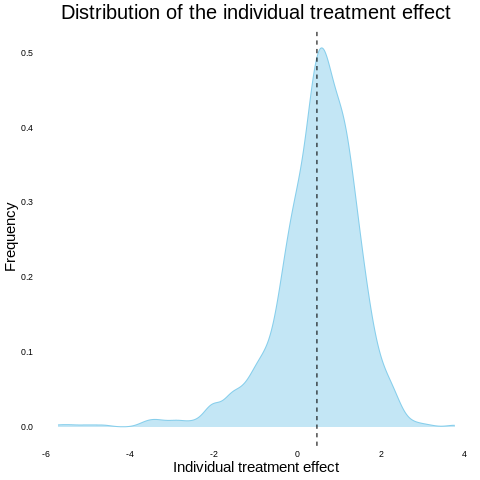

In [ ]:
%%R
# Create a CATE distribution plot
est_cate <- data.frame(est_cate = get_scores(forest_merged))

ggplot() +
  geom_density(data = est_cate, aes(x = est_cate), fill = "skyblue", color = "skyblue", alpha = 0.5) +
  geom_vline(xintercept = mean(est_cate$est_cate), linetype = 'dashed') +
  labs(x = "Individual treatment effect", y = "Frequency", title = "Distribution of the individual treatment effect") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.text = element_text(color='black'),
        plot.title = element_text(size = 20, hjust = 0.5),
        axis.title = element_text(size = 15))

Levene's Test for Homogeneity of Variance: p-value =  0.4874981
Mean of the low-ITE group: 0.3748211
Mean of the high-ITE group: 0.5600887
t-test results: t( 998 )  =  2.874881 , p-value =  0.00206383

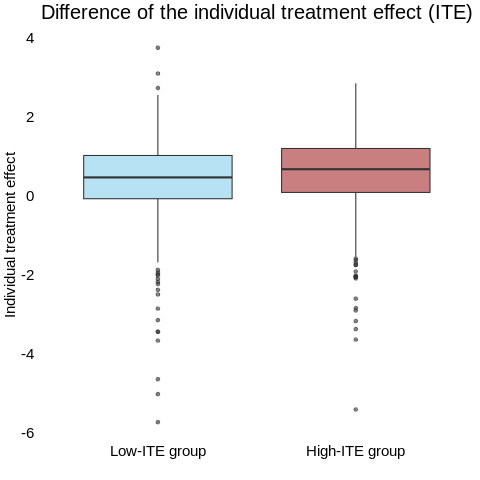

In [ ]:
%%R
# Compare the individual treatment effects between high- and low-effect groups
pred_ite <- predict(forest_merged)$predictions
num_rankings <- 2       # number of groups
ranking <- rep(NA, nrow(data))
pred_ite_quantiles <- quantile(pred_ite, probs = seq(0, 1, by = 1/num_rankings))
ranking <- cut(pred_ite, pred_ite_quantiles, include.lowest = TRUE, labels=seq(num_rankings))

# Estimate the treatment effect within groups
est_ite <- get_scores(forest_merged)
df <- data.frame(ranking, est_ite)

# Perform t-test between high- and low-effect groups
l_test <- leveneTest(est_ite ~ ranking, data = df)     # test for equal variances
cat("Levene's Test for Homogeneity of Variance: p-value = ", l_test$`Pr(>F)`[1])
ite_low <- df$est_ite[df$ranking == '1']
ite_high <- df$est_ite[df$ranking == '2']
t_test <- t.test(ite_high, ite_low, alternative = 'greater', paired = F, var.equal = T) # alternative = "greater" is the alternative that x has a larger mean than y
cat("\nMean of the low-ITE group:", mean(ite_low))
cat("\nMean of the high-ITE group:", mean(ite_high))
cat("\nt-test results:", "t(", t_test$parameter, ")", " = ", t_test$statistic, ", p-value = ", t_test$p.value)

# Visualize the results
ggplot(df, aes(x = ranking, y = est_ite, fill = ranking)) +
  geom_boxplot(alpha = 0.6) +
  labs(y = "Individual treatment effect", x = "", title = "Difference of the individual treatment effect (ITE)") +
  scale_fill_manual(values = c("skyblue", "brown")) +
  scale_x_discrete(labels = c('Low-ITE group','High-ITE group')) +
  theme_minimal() +
  theme(legend.position = "none",
        panel.grid = element_blank(),
        axis.title = element_text(size = 15),
        axis.text = element_text(size = 15, color = 'black'),
        plot.title = element_text(size = 20, hjust = 0.5))


### Best linear projection

In [ ]:
%%R
blp <- best_linear_projection(forest_merged, X)
blp <- as.data.frame(blp[,])
cat("Variables with significant BLP:\n")
print(blp[blp$'Pr(>|t|)' < 0.05,])

Variables with significant BLP:
                          Estimate Std. Error   t value    Pr(>|t|)
(Intercept)             0.52625433 0.17933643  2.934453 0.003422885
demo_sex_v2            -0.19200217 0.06880685 -2.790451 0.005370335
interview_age           0.07973504 0.03562744  2.238024 0.025453775
smri_vol_cdk_rracatelh  0.12439101 0.04542572  2.738339 0.006292143
smri_vol_cdk_mdtmrh     0.09124951 0.04500131  2.027708 0.042872675


### Variable importance

In [ ]:
%%R
# Variable importance
var_imp <- c(variable_importance(forest_merged))
names(var_imp) <- colnames(X)
sorted_var_imp <- sort(var_imp, decreasing = TRUE)   # sort in decreasing order
sorted_var_imp <- data.frame(importance = sorted_var_imp)
print(head(sorted_var_imp))

                           importance
smri_vol_cdk_parahpallh    0.05757310
smri_vol_cdk_rracaterh     0.03207018
smri_vol_cf12_pclh         0.03153482
smri_vol_cf12_supllh       0.03018995
smri_vol_scs_subcorticalgv 0.02823075
smri_vol_cdk_cuneusrh      0.02701466


In [ ]:
# %%R
# # Variable importance significance test
# var_imp_sign <- list()

# # Set the number of iterations
# num_iter <- 100

# for(iter in 1:num_iter){

#   # Permute the treatment variable
#   W_perm <- permute(W)

#   # Fit the forest model
#   forest <- causal_forest(X, Y, W_perm,
#                           Y.hat = NULL, W.hat = NULL,
#                           compute.oob.predictions = TRUE,
#                           num.trees = 1000,
#                           tune.parameters = 'all',
#                           num.threads = 16,
#                           seed = sample(1:10000, size = 1))

#   # Calculate and save variable importance
#   var_imp_iter <- c(variable_importance(forest))
#   var_imp_sign[[paste0('iter=', iter)]] <- var_imp_iter
# }

# # Calculate the 95th percentile
# var_imp_vec <- unlist(var_imp_sign)
# threshold <- quantile(var_imp_vec, probs = 0.95)
# cat("Variable importance significance threshold:", threshold)

Variable with significant variable importance: smri_vol_cdk_parahpallh (left parahippocampal gyrus)

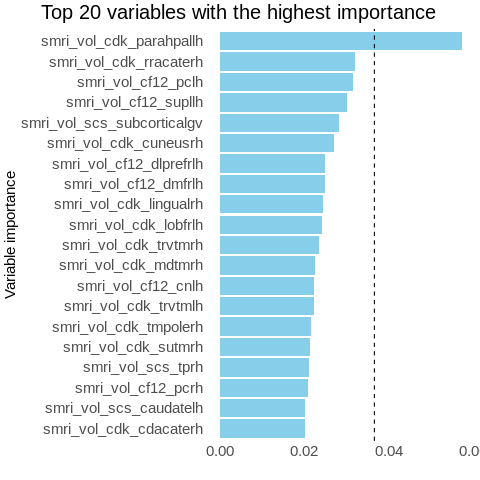

In [ ]:
%%R
# Visualize the results
sign_var_imp = rownames(sorted_var_imp)[sorted_var_imp$importance > threshold]
cat("Variable with significant variable importance:", sign_var_imp, "(left parahippocampal gyrus)")

ggplot(top20, aes(x = reorder(variable, importance), y = importance)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +
  geom_hline(yintercept = threshold, linetype = "dashed") +
  labs(x = "Variable importance",
       y = "",
       title = "Top 20 variables with the highest importance") +
  theme_minimal() +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 15),
        panel.grid = element_blank(),
        plot.title = element_text(size = 20, hjust = 1.3))

Left parahippocampal gyrus:

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Sobo_1909_630_-_Parahippocampal_gyrus.png" alt="description" width="300" height="300">


### Partial dependence plots

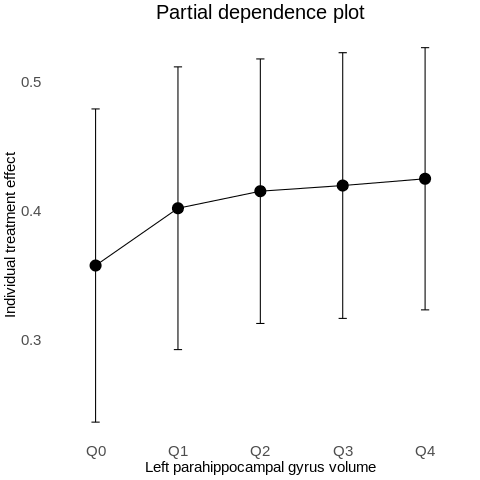

In [ ]:
%%R
# Set the covariate of interest
selected_covariate <- "smri_vol_cdk_parahpallh"
covariates <- names(X)
other_covariates <- covariates[which(covariates != selected_covariate)]

# Calculate percentiles for the selected covariate
percentiles <- c(0, .25, .5, .75, 1)
grid_size <- length(percentiles)
covariate_grid <- quantile(data[,selected_covariate], probs=percentiles)

# Take median of other covariates
medians <- apply(data[, other_covariates, F], 2, median)

# Construct a dataset
data_grid <- data.frame(sapply(medians, function(x) rep(x, grid_size)), covariate_grid)
colnames(data_grid) <- c(other_covariates, selected_covariate)
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse = "+")))
X_grid <- model.matrix(fmla, data_grid)

# Calculate predictions of the CATE and standard errors when other covariates are fixed at the median
forest_pred <- predict(forest_merged, newdata = X_grid, estimate.variance = TRUE)
tau_hat <- forest_pred$predictions
tau_hat_se <- sqrt(forest_pred$variance.estimates)
quantiles <- c('Q0','Q1','Q2','Q3','Q4')
univ_sim_data <- data.frame(quantiles, tau_hat)

# Create a partial dependence plot
ggplot(univ_sim_data, aes(x = quantiles, y = tau_hat, group = 1)) +
  geom_point(size = 5) +
  geom_line() +
  geom_errorbar(aes(ymin = tau_hat - tau_hat_se, ymax = tau_hat + tau_hat_se), width = 0.1) +
  labs(x = "Left parahippocampal gyrus volume", y = "Individual treatment effect", title = "Partial dependence plot") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_text(size = 15),
        axis.text = element_text(size = 15),
        plot.title = element_text(size = 20, hjust = 0.5))